1. Загрузка и предобработка данных

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('sources/AB_Test_Results.csv')

In [4]:
data.head(5)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,"0,00"
1,2423,control,"0,00"
2,9411,control,"0,00"
3,7311,control,"0,00"
4,6174,variant,"0,00"


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   USER_ID       10000 non-null  int64 
 1   VARIANT_NAME  10000 non-null  object
 2    REVENUE      10000 non-null  object
dtypes: int64(1), object(2)
memory usage: 234.5+ KB


In [6]:
data.columns = data.columns.str.lower().str.strip()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       10000 non-null  int64 
 1   variant_name  10000 non-null  object
 2   revenue       10000 non-null  object
dtypes: int64(1), object(2)
memory usage: 234.5+ KB


In [8]:
data['revenue'] = data['revenue'].str.replace(',', '.').astype(float)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       10000 non-null  int64  
 1   variant_name  10000 non-null  object 
 2   revenue       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [10]:
data.sort_values('revenue', ascending=False).head(5)

,user_id,variant_name,revenue
1437,3342,control,196.01
6447,2881,variant,58.63
7642,7206,variant,57.46
9421,6792,control,41.53
8168,2166,control,29.32


2. Разделение тестовой и контрольной групп

In [29]:
test_data = data[data['variant_name'] == 'variant']
control_data = data[data['variant_name'] == 'control']

test_data['user_id'].nunique(), control_data['user_id'].nunique()

(3934, 3931)

In [30]:
test_data = test_data.groupby('user_id')['revenue'].sum().reset_index()
control_data = control_data.groupby('user_id')['revenue'].sum().reset_index()

In [36]:
CR_test = test_data[test_data['revenue'] > 0]['revenue'].count()/test_data.shape[0]
CR_control = control_data[control_data['revenue'] > 0]['revenue'].count()/control_data.shape[0]

print('Доля платящих пользователей в тестовой и контрольной группах соответственно:', CR_test, CR_control)

Доля платящих пользователей в тестовой и контрольной группах соответственно: 0.018047788510421964 0.02035105571101501


3. Выбор метрики и формулирование гипотез

- CR (Convertion Rate) - конверсия в платящего пользователя  
CR = кол-во платящих пользователей / общее кол-во пользователей

H<sub>0</sub>: CR<sub>test</sub> = CR<sub>control</sub>  
H<sub>1</sub>: CR<sub>test</sub> &ne; CR<sub>control</sub> 


- ARPPU (Average Revenue per Paing User) - средний доход на платящего пользователя  
ARPPU = общая сумма заказов платящих пользователей / кол-во платящих пользователей

H<sub>0</sub>: ARPU<sub>test</sub> = ARPU<sub>control</sub>  
H<sub>1</sub>: ARPU<sub>test</sub> &ne; ARPU<sub>control</sub> 

4. Выбор статистического теста

- Для CR используем z-тест для пропорций
- Для ARPPU проверяем данные на нормальность:  
если данные распределены нормально - используем t-test  
если данные распределены не нормально - критерий манна-уитни

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.stats.proportion as smp
from scipy import stats #понадобится для вычисления p-value

5. Расчёт результатов z-теста для пропорций

In [49]:
# z-тест для пропорций

successes = [test_data[test_data['revenue'] > 0]['revenue'].count(), control_data[control_data['revenue'] > 0]['revenue'].count()]
nobs = [test_data.shape[0], control_data.shape[0]]

# Выполняем Z-тест
zstat, pval = smp.proportions_ztest(successes, nobs)

print(f"Z-test для пропорций: statistic={zstat:.3f}, p-value={pval:.3f}")

Z-test для пропорций: statistic=-0.744, p-value=0.457


<span style="color: gray;">СЕРЫЙ</span> результат теста: доля платящих пользователей не значимо уменьшилась!

6. Проверка на нормальность распределений

In [54]:
def check_normality(data, column_name, group_name):
    """
    Строит гистограмму и QQ-plot в одной строке (subplot) и проводит тест Шапиро-Уилка для указанного столбца данных.

    Args:
        data (pd.DataFrame): DataFrame, содержащий данные.
        column_name (str): Имя столбца, для которого нужно провести анализ нормальности.
        group_name (str): Имя группы (для заголовков графиков).

    Returns:
        None
    """

    print(f"Анализ нормальности для столбца '{column_name}' (группа '{group_name}'):")

    # Создаем figure и axes
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 строка, 2 столбца

    # 1. Гистограмма
    axes[0].hist(data[column_name], bins=30, density=True, alpha=0.6, color='skyblue')  # density=True для нормализации
    axes[0].set_title(f'Гистограмма для {group_name}')
    axes[0].set_xlabel('Значение')
    axes[0].set_ylabel('Плотность')

    # Накладываем график нормального распределения (для сравнения)
    mu, std = data[column_name].mean(), data[column_name].std()
    xmin, xmax = axes[0].get_xlim()  # Используем get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    axes[0].plot(x, p, 'k', linewidth=2)


    # 2. QQ-plot
    stats.probplot(data[column_name], dist="norm", plot=axes[1])
    axes[1].set_title(f'QQ-plot для {group_name}')
    axes[1].set_xlabel('Теоретические квантили')
    axes[1].set_ylabel('Эмпирические квантили')


    plt.tight_layout()  # Автоматическая корректировка расположения графиков
    plt.show()

    # 3. Тест Шапиро-Уилка
    shapiro_test = stats.shapiro(data[column_name])
    print(f"Тест Шапиро-Уилка: statistic={shapiro_test.statistic:.3f}, p-value={shapiro_test.pvalue:.3f}")

    # Интерпретация теста Шапиро-Уилка
    alpha = 0.05
    if shapiro_test.pvalue > alpha:
        print(f"p-значение ({shapiro_test.pvalue:.3f}) > {alpha}: Не отвергаем нулевую гипотезу.  Распределение {group_name} выглядит нормально.")
    else:
        print(f"p-значение ({shapiro_test.pvalue:.3f}) <= {alpha}: Отвергаем нулевую гипотезу. Распределение {group_name} не выглядит нормально.")
    print("-" * 40)

Анализ нормальности для столбца 'revenue' (группа 'test_data'):


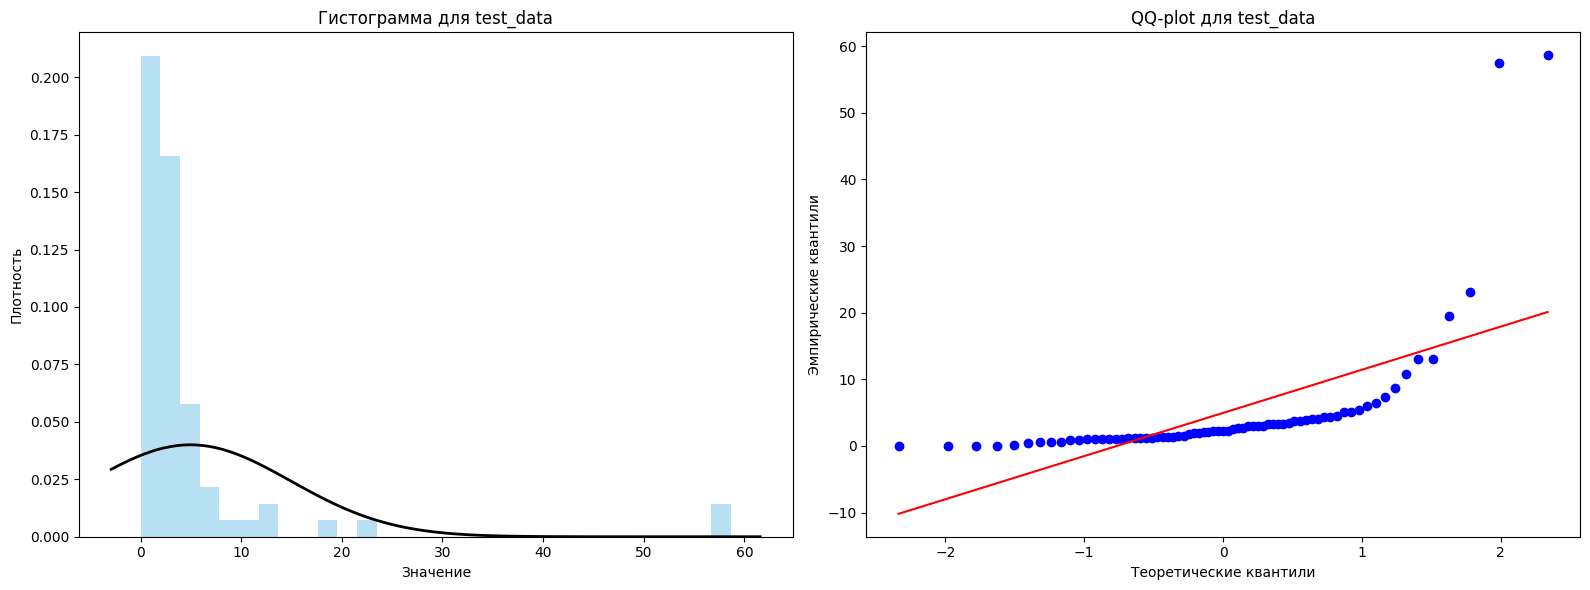

Тест Шапиро-Уилка: statistic=0.420, p-value=0.000
p-значение (0.000) <= 0.05: Отвергаем нулевую гипотезу. Распределение test_data не выглядит нормально.
----------------------------------------
Анализ нормальности для столбца 'revenue' (группа 'control_data'):


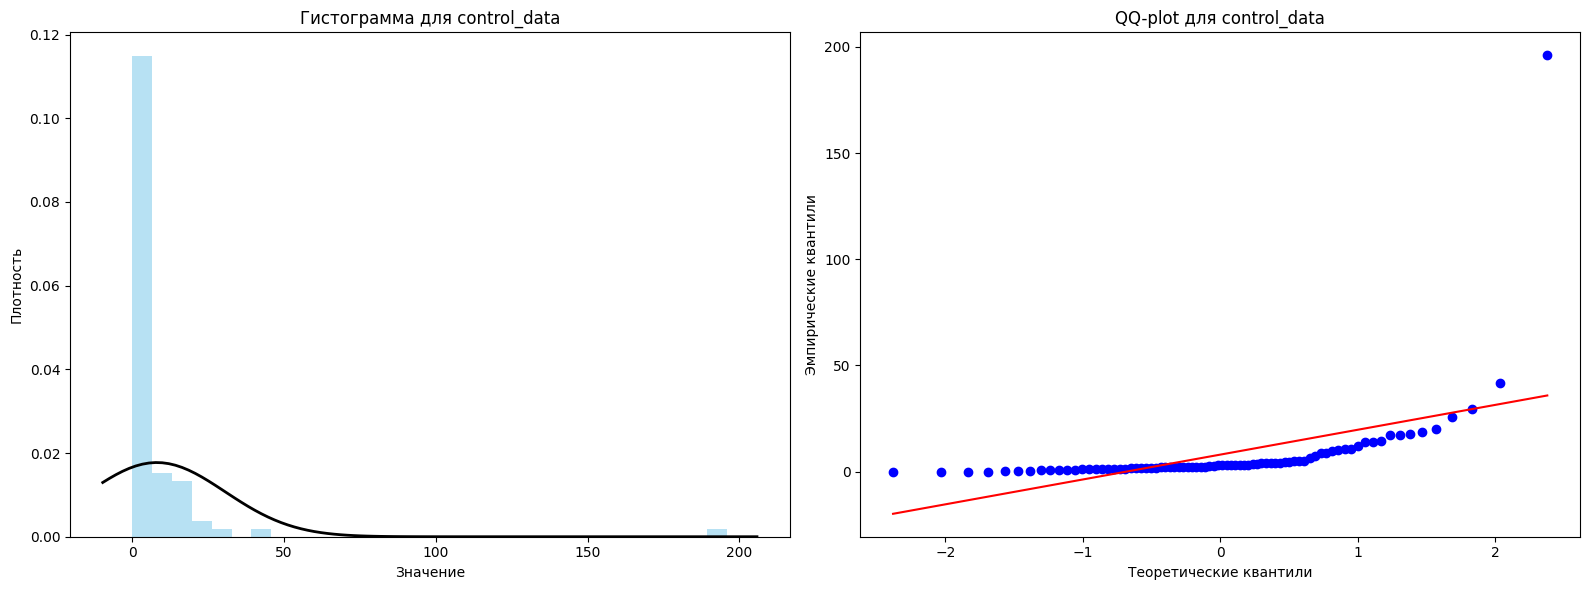

Тест Шапиро-Уилка: statistic=0.281, p-value=0.000
p-значение (0.000) <= 0.05: Отвергаем нулевую гипотезу. Распределение control_data не выглядит нормально.
----------------------------------------


In [55]:
check_normality(test_data[test_data['revenue'] > 0], 'revenue', 'test_data')
check_normality(control_data[control_data['revenue'] > 0], 'revenue', 'control_data')

В обеих группах ARPPU распределен не нормально. Значит, мы не можем приметить t-тест. Используем непараметрический тест Манна-Уитни.

7. Расчёт результатов непараметрического теста Манна-Уитни

In [57]:
test_revenue_paying = test_data[test_data['revenue'] > 0]['revenue']
control_revenue_paying = control_data[control_data['revenue'] > 0]['revenue']

mannwhitneyu_result = stats.mannwhitneyu(test_revenue_paying, control_revenue_paying)
print(f"Mann-Whitney U test для платящих пользователей: statistic={mannwhitneyu_result.statistic:.3f}, p-value={mannwhitneyu_result.pvalue:.3f}")

Mann-Whitney U test для платящих пользователей: statistic=2407.000, p-value=0.107


p-value=0.107>0.05  
<span style="color: gray;">СЕРЫЙ</span> результат теста.
Не отвергаем H<sub>0</sub>: ARPPU<sub>test</sub> = ARPPU<sub>control</sub>   
Нельзя утверждать, что ARPPU в тестовой группе значимо отличается от ARPPU в контрольной группе.  
РЕКОМЕНДАЦИЯ: не вносить изменения.

На всякий случай проверим то же самое для ARPU.

In [79]:
mannwhitneyu_result = stats.mannwhitneyu(test_data['revenue'], control_data['revenue'])
print(f"Mann-Whitney U test для платящих пользователей: statistic={mannwhitneyu_result.statistic:.3f}, p-value={mannwhitneyu_result.pvalue:.3f}")

Mann-Whitney U test для платящих пользователей: statistic=7714034.500, p-value=0.446


p-value=0.107>0.05  
<span style="color: gray;">СЕРЫЙ</span> результат теста.
Не отвергаем H<sub>0</sub>: ARPU<sub>test</sub> = ARPPU<sub>control</sub>   
Нельзя утверждать, что ARPU в тестовой группе значимо отличается от ARPU в контрольной группе.  
РЕКОМЕНДАЦИЯ: не вносить изменения.

8. Валидация результатов: A/A-тест

Проведем те же самые тесты для двух выборок, взятых из контрольной группы.

In [70]:
def assign_to_group(user_id, num_groups=2):
    """Назначает пользователя в группу на основе хэша user_id."""
    return hash(user_id) % num_groups

# Применение функции для назначения в подгруппы (C1 или C2)
control_data['group'] = control_data['user_id'].apply(assign_to_group).map({0: 'C1', 1: 'C2'})

In [74]:
control_data_C1 = control_data[control_data['group'] == 'C1']
control_data_C2 = control_data[control_data['group'] == 'C2']

In [75]:
# z-тест для пропорций

successes = [control_data_C1[control_data_C1['revenue'] > 0]['revenue'].count(), control_data_C2[control_data_C2['revenue'] > 0]['revenue'].count()]
nobs = [control_data_C1.shape[0], control_data_C2.shape[0]]

# Выполняем Z-тест
zstat, pval = smp.proportions_ztest(successes, nobs)

print(f"Z-test для пропорций: statistic={zstat:.3f}, p-value={pval:.3f}")

Z-test для пропорций: statistic=0.800, p-value=0.424


p-value=0.424>0.05  
Нет стат. значимой разницы. На основании этих результатов система A/B-тестирования признана валидной.

In [76]:
control_revenue_paying_С1 = control_data_C1[control_data_C1['revenue'] > 0]['revenue']
control_revenue_paying_С2 = control_data_C2[control_data_C2['revenue'] > 0]['revenue']

mannwhitneyu_result = stats.mannwhitneyu(control_revenue_paying_С1, control_revenue_paying_С2)
print(f"Mann-Whitney U test для платящих пользователей: statistic={mannwhitneyu_result.statistic:.3f}, p-value={mannwhitneyu_result.pvalue:.3f}")

Mann-Whitney U test для платящих пользователей: statistic=752.500, p-value=0.706


p-value=0.424>0.05  
Нет стат. значимой разницы. На основании этих результатов система A/B-тестирования признана валидной.

9. Результаты и рекомендации

A/B-тестирование показало серый результат: нет статистически значимой разницы ни по метрике CR (конверсия в платящего пользователя), ни по метрике ARPPU (средний доход с платящего пользователя), ни по метрике ARPU (средний доход с пользователя). Рекомендуется не внедрять изменения в систему.